- 매장(ex. KT 식당)관리자
- 요즘 음식 재고로 인해서 골치를 썩고있음...
- 매번 식수를 감으로 예측하지만, 어떤 날에는 적게, 어떤 날에는 많게 식당을 이용하는 상황이 허다하여, **재고관리측면**에서 손실을 보고 있음

> 메뉴 정보와 근무자의 정보 data를 활용하여, 식수(식사 횟수, 이용 횟수)를 예측하거나 재고를 효율적으로 관리하려고 함

```python
# 워드클라우드를 위한 한글 폰트 설치
!apt-get install -y fonts-nanum*
# 나눔폰트 지정하여 설치

!sudo fc-cache -fv
# sudo -> 관리자 권한으로 실행
# 폰트 캐시 업데이트

!rm ~/.cache/matplotlib -rf
# 기존에 matplotlib 세팅되어있던 캐시 디렉토리 삭제
```

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/강의 자료들/2024/240821 인사교 Track1 (A) 강의자료/ML

/content/drive/MyDrive/강의 자료들/2024/240821 인사교 Track1 (A) 강의자료


In [ ]:
!pwd

/content/drive/MyDrive/강의 자료들/2024/240821 인사교 Track1 (A) 강의자료


In [ ]:
# 세션 다시 시작(install 반영을 위함) 후 불러오기!
import matplotlib.pyplot as plt
plt.rc("font", family = "NanumBarunGothic") # 한글 설정
plt.rcParams["axes.unicode_minus"] = False # 마이너스 기호("-")를 표시로 설정!

In [ ]:
import warnings
warnings.filterwarnings("ignore") # 경고메세지 무시

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("./data/Cafeteria.csv")

In [ ]:
df.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,month,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥/잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥/잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039.0,331.0,2,쥐어채무침,오징어찌개,건파래무침
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 호박젓국찌개 시래기조림 포...,쌀밥/잡곡밥 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이,콩나물밥*양념장 어묵국 유산슬 아삭고추무침 바나나 포기김치,867.0,560.0,2,단호박샌드,김치찌개,콩나물밥
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 콩나물국 느타리호박볶음 ...,카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트 포기김치,쌀밥/잡곡밥 청국장찌개 황태양념구이 고기전 새송이버섯볶음 포기김치,1017.0,573.0,2,느타리호박볶음,견과류조림,새송이버섯볶음


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1162 non-null   object 
 1   요일              1162 non-null   object 
 2   본사정원수           1162 non-null   int64  
 3   본사휴가자수          1162 non-null   int64  
 4   본사출장자수          1162 non-null   int64  
 5   본사시간외근무명령서승인건수  1162 non-null   int64  
 6   현본사소속재택근무자수     1162 non-null   float64
 7   조식메뉴            1162 non-null   object 
 8   중식메뉴            1162 non-null   object 
 9   석식메뉴            1162 non-null   object 
 10  중식계             1162 non-null   float64
 11  석식계             1162 non-null   float64
 12  month           1162 non-null   int64  
 13  조식메뉴_Main       1162 non-null   object 
 14  중식메뉴_Main       1162 non-null   object 
 15  석식메뉴_Main       1162 non-null   object 
dtypes: float64(3), int64(5), object(8)
memory usage: 145.4+ KB


### 모델링을 위한 데이터 준비
- 데이터 스케일링 -> 수치형 데이터들
  - 거리기반, linear 기반 모델들은 특성(X)의 값 자체에 영향을 많이 받음 (영향을 받지 않는 모델은 DT 기반)
  - 모든 Feature가 동일한 스케일을 가지도록 값을 재조정
  - 장점 : 모델의 성능 향상
  - 단점 : 원래의 값을 잃어버림 -> 스케일링 이후의 값은 해석하기가 어려움

- 인코딩 -> 범주형 데이터들

In [ ]:
df.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,month,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥/잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥/잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039.0,331.0,2,쥐어채무침,오징어찌개,건파래무침
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 호박젓국찌개 시래기조림 포...,쌀밥/잡곡밥 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이,콩나물밥*양념장 어묵국 유산슬 아삭고추무침 바나나 포기김치,867.0,560.0,2,단호박샌드,김치찌개,콩나물밥
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 콩나물국 느타리호박볶음 ...,카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트 포기김치,쌀밥/잡곡밥 청국장찌개 황태양념구이 고기전 새송이버섯볶음 포기김치,1017.0,573.0,2,느타리호박볶음,견과류조림,새송이버섯볶음


In [ ]:
# 불필요한 컬럼 삭제
df.drop(columns = ["일자", "조식메뉴", "중식메뉴", "석식메뉴"], inplace = True)
# 일자 -> month로 대체
# 메뉴 -> MainMenu를 활용할 예정

In [ ]:
# 데이터 타입 나누기
df["석식메뉴_Main"].dtype == "O"

True

In [ ]:
# 수치형, 범주형 컬럼(인덱스 재료) 나눠주기
numeric_list = [] # 수치형 컬럼명
categorical_list = [] # 범주형 컬럼명

for column in df.columns :
  if df[column].dtype == "O" : # 해당 컬럼의 dtype이 object형인지 확인
    categorical_list.append(column)
  else :
    numeric_list.append(column)

In [ ]:
numeric_list, categorical_list

(['본사정원수',
  '본사휴가자수',
  '본사출장자수',
  '본사시간외근무명령서승인건수',
  '현본사소속재택근무자수',
  '중식계',
  '석식계',
  'month'],
 ['요일', '조식메뉴_Main', '중식메뉴_Main', '석식메뉴_Main'])

#### 스케일링 선택, 적용을 위한 데이터 분포 확인
1. StandardScaler : 데이터들을 평균이 0, 표준편차가 1이 되도록 변환
  - 데이터가 정규분포를 따르는 경우 유용
<br><br>
2. MinMaxScaler : 데이터들을 고정된 범위(보통은 0 ~ 1)로 변환
  - 데이터가 비정규분포를 따르는 경우 유용

In [ ]:
# 차트 스타일을 어둡게 설정
plt.style.use(["dark_background"]) # 보통 더 잘보임

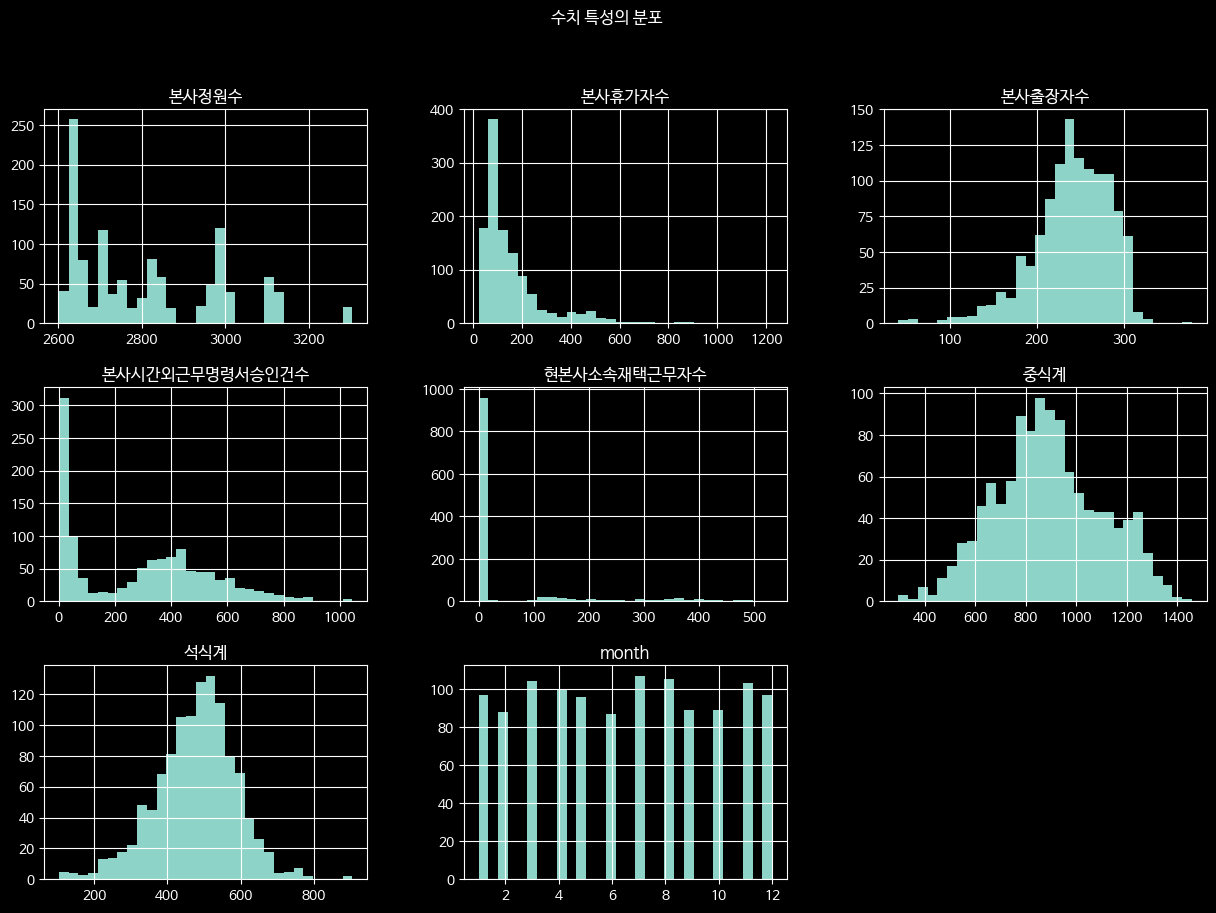

In [ ]:
# 분포 확인(히스토그램 그려보기)
df[numeric_list].hist(
    bins = 30, # 히스토그램 막대 개수
    figsize = (15, 10)
)
plt.suptitle("수치 특성의 분포")
plt.show()
# 정규분포(값이 평균을 중심으로 고르게 분포되어 있음) : 중식계, 석식계
# 정규분포에 가까움 : 분사출장자수
# 그 외 컬럼 : 비정규분포(특정 구간에 값이 집중되는 경향이 있거나, 일부 높은 피크들이 다수 존재함)
# month는 균등분포 -> 균등하게 분포되어 있음

##### 스케일링 방법 선택
- 모든 Feature가 동일한 스케일을 가지도록 **하나의 스케일링 방법**으로 일관되게 처리하는 것이 중요
- 대부분의 Feature들이 정규 분포를 따르지 않아서, MinMaxScaler 선택!

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler() # 스케일러 초기화(생성)

In [ ]:
# df2 = df # 얕은 복사 -> 주소값을 공유 -> 복사본(df2)를 바꾸면 원본(df)도 데이터가 바뀜
df_scaled = df.copy() # 강한 복사 -> 주소값을 따로따로 생성(진짜 복사본을 생성!)
df_scaled[numeric_list] = scaler.fit_transform(df_scaled[numeric_list])

In [ ]:
df_scaled

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
0,월,0.000000,0.022481,0.323442,0.227969,0.000000,0.638865,0.283396,0.090909,쥐어채무침,오징어찌개,건파래무침
1,화,0.000000,0.022481,0.391691,0.305556,0.000000,0.490972,0.569288,0.090909,단호박샌드,김치찌개,콩나물밥
2,수,0.000000,0.027477,0.412463,0.106322,0.000000,0.619948,0.585518,0.090909,느타리호박볶음,견과류조림,새송이버섯볶음
3,목,0.000000,0.067444,0.531157,0.340038,0.000000,0.586414,0.525593,0.090909,근대국,부추전,미니김밥
4,금,0.000000,0.212323,0.415430,0.032567,0.000000,0.540843,0.282147,0.090909,방풍나물,돈육씨앗강정,감자소세지볶음
...,...,...,...,...,...,...,...,...,...,...,...,...
1157,수,0.542614,0.043297,0.465875,0.003831,0.733583,0.685297,0.395755,0.000000,마늘종숙회,견과류마카로니범벅,맛살튀김
1158,목,0.542614,0.057452,0.563798,0.442529,0.658537,0.460877,0.310861,0.000000,생크림단팥빵,버섯숙회,비엔나채소볶음
1159,금,0.542614,0.193172,0.614243,0.000958,0.568480,0.243336,0.141074,0.000000,바지락살국,계란파국,수제맛쵸킹탕수육
1160,월,0.542614,0.069942,0.332344,0.590038,0.613508,0.730009,0.496879,0.000000,분홍소세지구이,양념김,생강채


#### 수치데이터 상관관계 분석

In [ ]:
import seaborn as sns

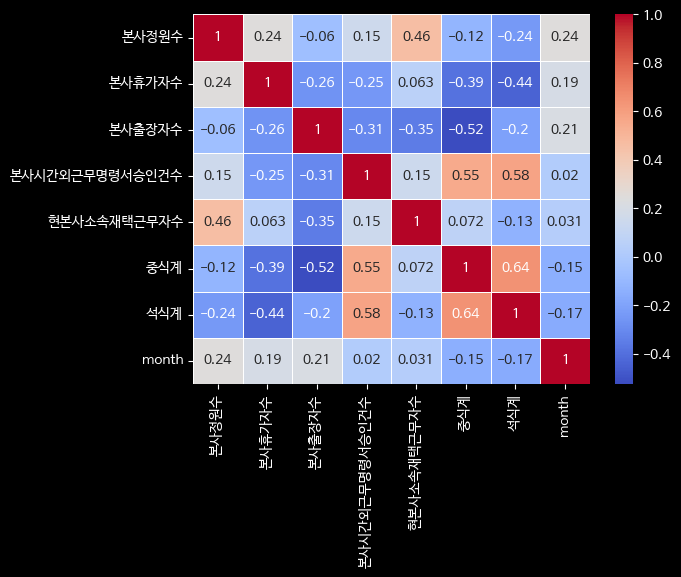

In [ ]:
corr_matrix = df_scaled[numeric_list].corr() # 상관계수 테이블

sns.heatmap(
    corr_matrix,
    annot = True, # 각 셀에 상관계수 값을 표시
    cmap = "coolwarm", # 색상 맵
    linewidths = 0.5 # 셀끼리의 경계선
)
plt.show()
# 상관관계가 높은 피쳐들은 클러스터링에 큰 영향을 미칠 수 있음

### 인코딩 적용

In [ ]:
df_scaled[categorical_list].describe().T

,count,unique,top,freq
요일,1162,5,목,244
조식메뉴_Main,1162,570,김잔파무침,9
중식메뉴_Main,1162,888,견과류조림,6
석식메뉴_Main,1162,905,닭살겨자냉채,5


In [ ]:
# 요일 -> 원한인코딩 수행
df_scaled = pd.get_dummies(df_scaled, columns=["요일"])

In [ ]:
df_scaled["중식메뉴_Main"].unique()
# 메인 메뉴 데이터들은 고유값들이 너무 많아서, 원-핫 인코딩을 수행하면 차원이 크게 증가할 수 있음 -> 복잡도가 올라감 -> 과대적합에 빠질 경향이 높아짐!

array(['오징어찌개', '김치찌개', '견과류조림', '부추전', '돈육씨앗강정', '시래기국', '유채나물', '닭감자조림',
       '쇠고기무국', '냉이된장국', '요구르트', '새송이버섯볶음', '고사리', '꽃상추무침', '맛탕', '곰피초장',
       '도라지초무침', '치커리생채', '맛살계란말이', '새송이버섯조림', '열무된장나물', '모둠묵', '소세지구이',
       '홍어무침', '닭데리야끼조림', '수제돈가스', '모둠양채쌈', '쑥국', '두부계란부침', '깻순나물',
       '연근땅콩조림', '도토리묵무침', '두부', '치킨텐더', '시래기나물', '자반고등어구이', '해파리냉채',
       '옹심이만두국', '봄새싹비빔밥', '봄동나물', '버섯들깨탕', '브로컬리맛살볶음', '모둠소시지구이',
       '올갱이아욱국', '매운돼지갈비찜', '순살양념치킨', '풋마늘초무침', '쇠고기단호박조림', '수제비국',
       '냉이된장찌개', '브로컬리두부무침', '꽁치한마리구이', '매콤떡갈비조림', '쇠고기볶음', '깻잎양념지',
       '돈간장불고기', '치즈계란말이', '궁중떡찜', '동그랑땡부침', '고등어카레구이', '맛살겨자채', '볶은김치',
       '동태전', '매운어묵국', '오징어초무침', '멸치크랜베리볶음', '찜닭', '치커리유자생채', '감자고추장찌개',
       '들깨버섯탕', '산채비빔밥', '미니채소떡갈비', '불미나리무침', '쇠고기불고기', '꼬지삼색전', '낙지볶음밥',
       '쇠고기해장국', '닭양념조림', '명태조림', '강된장찌개', '오이미역냉국', '머위대나물', '북어계란국',
       '맛살콩나물냉채', '매운콩나물국', '북어콩나물국', '가자미양념찜', '김구이', '명태엿장조림', '간장치킨',
       '돈삼겹보쌈', '매콤낙지볶음', '목살데리야끼구이', '야채스틱', '닭가슴살냉채', '간장돼지갈비찜',
     

### 빈도 인코딩(Frequency Encoding)
- 각 범주(ex.오므라이스)를 해당 범주의 빈도수(ex.오므라이스의 빈도수)로 대체
- 범주형의 발생 빈도를 반영 -> 어느정도 "정보"로써의 가치로 활용해볼 수는 있음
- 단점 : 빈도가 같을 때는 구분이 어려움
---
- 빈도인코딩은 군집화 분석에서 메뉴의 빈도가 식수에 어떤 영향을 미치는지 분석하는데 유용하게 활용 가능

In [ ]:
categorical_list[1:] # 요일은 제외

['조식메뉴_Main', '중식메뉴_Main', '석식메뉴_Main']

In [ ]:
df_scaled["조식메뉴_Main"].value_counts().to_dict()

{'김잔파무침': 9,
 '북어국': 9,
 '쑥갓두부무침': 8,
 '도라지나물': 8,
 '연두부탕': 8,
 '브로컬리들깨찜': 7,
 '대구찌개': 7,
 '두부쑥갓무침': 7,
 '쇠고기무국': 7,
 '꽈리고추찜': 7,
 '대구매운탕': 7,
 '느타리볶음': 7,
 '문어꽈리초조림': 7,
 '무생채': 6,
 '느타리호박볶음': 6,
 '조랭이떡국': 6,
 '열무나물': 6,
 '브로컬리초장': 6,
 '선지해장국': 6,
 '시래기국': 6,
 '마늘쫑볶음': 6,
 '재첩국': 6,
 '브로컬리죽': 6,
 '맑은만두육개장': 6,
 '미역국': 6,
 '땅콩조림': 6,
 '대구탕': 6,
 '어묵볶음': 6,
 '매운버섯국': 6,
 '핫케익': 6,
 '단배추나물': 5,
 '올챙이만두국': 5,
 '차돌박이찌개': 5,
 '동전쥐포무침': 5,
 '버섯매운탕': 5,
 '콩나물김치국': 5,
 '노각무침': 5,
 '동태찌개': 5,
 '삶은계란': 5,
 '감자조림': 5,
 '우거지해장국': 5,
 '참치야채죽': 5,
 '아욱국': 5,
 '고구마순나물': 5,
 '김치국': 5,
 '홍합탕': 5,
 '콩나물무침': 5,
 '북어해장국': 5,
 '김치두부국': 5,
 '팬케익': 5,
 '건새우아욱국': 5,
 '롤케익': 5,
 '연두부국': 5,
 '배추된장국': 5,
 '오이무침': 5,
 '된장찌개': 5,
 '두부젓국찌개': 5,
 '북어계란국': 4,
 '시금치핫케익': 4,
 '구운계란': 4,
 '호박죽': 4,
 '영양부추생채': 4,
 '콩자반': 4,
 '새송이볶음': 4,
 '시금치국': 4,
 '마늘쫑건새우볶음': 4,
 '깻순나물': 4,
 '볼어묵조림': 4,
 '오징어국': 4,
 '비름나물': 4,
 '미역나물': 4,
 '호두죽': 4,
 '새송이버섯볶음': 4,
 '진미채볶음': 4,
 '유채나물': 4,
 '볼어묵볶음': 4,
 '올갱이아욱국': 4,
 '두부양념조림': 4,
 '밤죽':

In [ ]:
# map({기존에 있던 값:바꾸고자 값}) : 매핑할 때 사용

for column in categorical_list[1:] :
  map_dict = df_scaled[column].value_counts().to_dict() # key(메뉴)와 value(빈도)를 가진 딕셔너리 생성
  df_scaled[f"{column}_encoded"] = df_scaled[column].map(map_dict) # 매핑한 이후에 OO메뉴_encoded 라는 컬럼으로 추가

In [ ]:
df_scaled.head(3)

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main,요일_금,요일_목,요일_수,요일_월,요일_화,조식메뉴_Main_encoded,중식메뉴_Main_encoded,석식메뉴_Main_encoded
0,0.0,0.022481,0.323442,0.227969,0.0,0.638865,0.283396,0.090909,쥐어채무침,오징어찌개,건파래무침,False,False,False,True,False,1,1,3
1,0.0,0.022481,0.391691,0.305556,0.0,0.490972,0.569288,0.090909,단호박샌드,김치찌개,콩나물밥,False,False,False,False,True,4,3,3
2,0.0,0.027477,0.412463,0.106322,0.0,0.619948,0.585518,0.090909,느타리호박볶음,견과류조림,새송이버섯볶음,False,False,True,False,False,6,6,1


In [ ]:
# 문자형 컬럼들은 삭제!
df_encoded = df_scaled.drop(columns = categorical_list[1:])
df_encoded.head(3)

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,요일_금,요일_목,요일_수,요일_월,요일_화,조식메뉴_Main_encoded,중식메뉴_Main_encoded,석식메뉴_Main_encoded
0,0.0,0.022481,0.323442,0.227969,0.0,0.638865,0.283396,0.090909,False,False,False,True,False,1,1,3
1,0.0,0.022481,0.391691,0.305556,0.0,0.490972,0.569288,0.090909,False,False,False,False,True,4,3,3
2,0.0,0.027477,0.412463,0.106322,0.0,0.619948,0.585518,0.090909,False,False,True,False,False,6,6,1


### Kmeans 알고리즘
- 쉽고 간결함
- 거리 기반 알고리즘으로 특성의 개수가 많은 경우(차원 수가 높은 경우), 군집화 정확도가 떨어짐
- 몇 개의 군집(k수) 수를 선택해야 하는데, 여러가지 방법이 존재함!

In [ ]:
!pip install mglearn
# 머신러닝 교육 및 시각화를 위한 도구들을 제공하는 패키지

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 10.6 MB/s eta 0:00:00


In [ ]:
from sklearn.cluster import KMeans

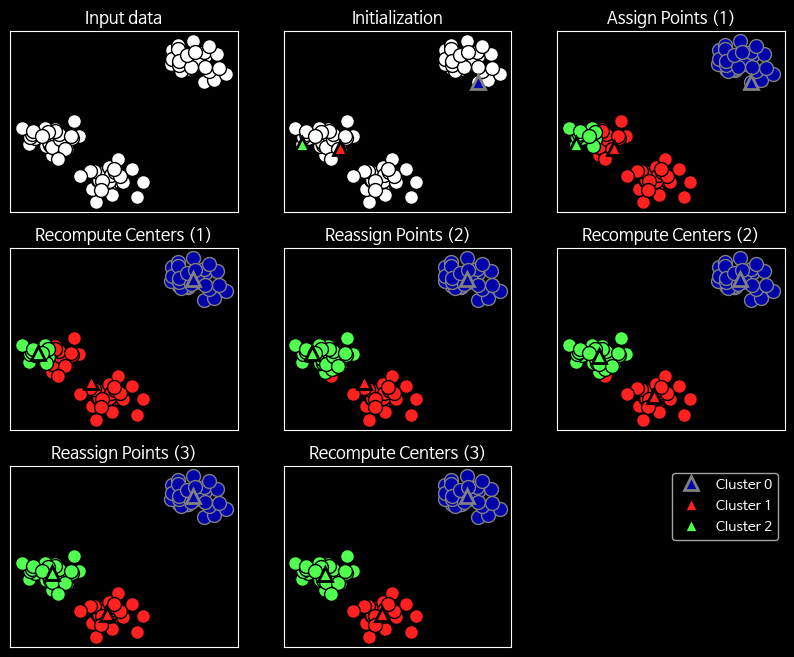

In [ ]:
import mglearn
mglearn.plots.plot_kmeans_algorithm()

In [ ]:
# 모델 초기화(생성)
model = KMeans(
    n_clusters = 3, # 클러스터 수 설정
    random_state = 2024, # 시드 고정
    n_init = 10 # 초기 centroid가 무작위로 선택하는 횟수를 지정, 가장 괜찮은(군집이 잘 나뉘었는가?) 결과를 선택
)

In [ ]:
# 학습
model.fit(df_encoded)

KMeans(n_clusters=3, n_init=10, random_state=2024)

In [ ]:
# 예측
pd.Series(model.predict(df_encoded)).value_counts()

,count
1,490
0,472
2,200


#### 거리기반 군집화 알고리즘의 최적화 된 클러스터 수를 결정하기 위한 4가지 방법
1. 관성과 군집수 -> 엘보우 기법
2. 실루엣 평균 점수와 군집수
3. 실루엣 다이어그램와 군집수
4. 계층 군집(병합, 분할) 활용한 군집수 설정
- 엘보우 지수뿐만 아니라, 실루엣 계수나 계층 군집을 활용한 덴드로그램 등을 활용하여 다방면에서 관측하고, K수를 결정짓는 것이 올바른 방안

##### 1. 관성과 군집수(엘보우 기법)
- 엘보우 차트에서 가장 완만해지는 k수를 찾는 방법 -> 가장 효율적인 클러스터링의 수를 의미
  - 왜 완만한 지점인가?
    - 엘보우 지점 : 급격히 감소하는 SSE가 더 이상 큰 폭으로 감소하지 않고, 변화율이 완만해지는 지점
    - 엘보우 지점 이후로 클러스터 수를 증가시켜도 SSE의 감소율이 급격히 줄어듬
    - 즉, 더 많은 클러스터를 추가해도 클러스터 내에 있는 데이터 포인트들은 중심에 더 가까워지지 않기 때문에 얻는 이득이 없으므로, 엘보우 지점을 기반으로 선정

In [ ]:
# 시각화
ks = range(1, 31) # 클러스터 범위 설정

In [ ]:
print(model.inertia_) # SSE

# 각 클러스터 개수에 대해 KMean 모델을 학습하고 SSE(중심점으로부터의 거리값)를 계산
k_means = [KMeans(random_state = 2024, n_init = 10, n_clusters = k).fit(df_encoded) for k in ks] # 시드 고정 : 2024, n_init = 10
inertias = [model.inertia_ for model in k_means]

3534.3412440404613


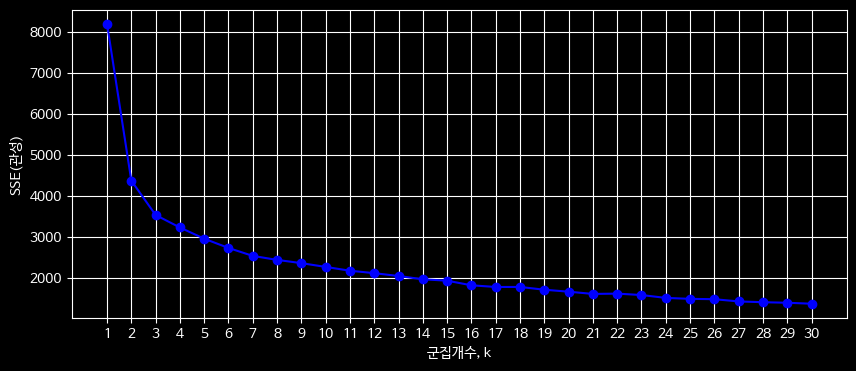

In [ ]:
# 엘보우 차트 -> x : k수, y : SSE(관성)
plt.figure(figsize = (10, 4))
plt.plot(ks, inertias, "bo-") # 파란색 점과 선

plt.xlabel("군집개수, k")
plt.ylabel("SSE(관성)")

plt.xticks(ks)
plt.grid()

plt.show()
# 엘보우 포인트는 클러스터 수가 2 or 3으로 관측이 됨
# 엘보우 메소드만이 절대적인 값은 아님!! -> 잘 나누었는지에 대한 지표값이 아님!!

##### 2. 실루엣 평균 점수와 군집수
- 실루엣 계수 : 얼마나 효율적으로 잘 분리되었는지를 나타내는 값
- -1에 가까울수록 잘 못 군집화 됨(또는 데이터 셋 자체가 거리기반 알고리즘으로 군집화 할 수 없는 데이터셋)
- 0에 가까울수록 애매함!
- 1에 가까울수록 잘 나눴다!

In [ ]:
from sklearn.metrics import silhouette_score # 전체 데이터에 대한 평균 실루엣 계수 구해주는 도구

In [ ]:
k_means[3].labels_

array([1, 0, 2, ..., 3, 3, 3], dtype=int32)

In [ ]:
silhouette_score(df_encoded, k_means[1].labels_) # 실루엣 계수 평균

0.3843645091591921

In [ ]:
# 각 클러스터 수에 대한 실루엣 계수 평균 계산
sil_mean_score = [silhouette_score(df_encoded, model.labels_) for model in k_means[1:]]

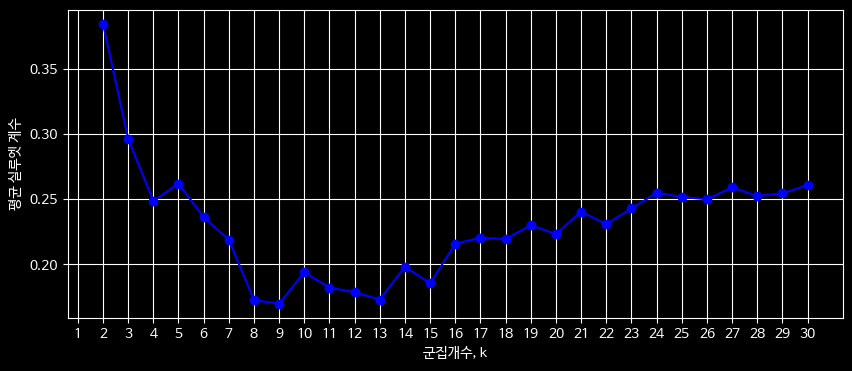

In [ ]:
plt.figure(figsize = (10, 4))
plt.plot(ks[1:], sil_mean_score, "bo-") # 파란색 점과 선

plt.xlabel("군집개수, k")
plt.ylabel("평균 실루엣 계수")

plt.xticks(ks)
plt.grid()

plt.show()
# 엘보우 아님! -> 완만한 지점 찾는게 아님!!
# k수 2가 가장 높은 평균 실루엣 계수를 보임!! -> 가장 적절한 최적의 클러스터 수는 2로 관측이 됨

##### 3. 실루엣 다이어그램와 군집수
- 각 군집별로 샘플의 실루엣 계수를 오름차순으로 정렬한 그래프

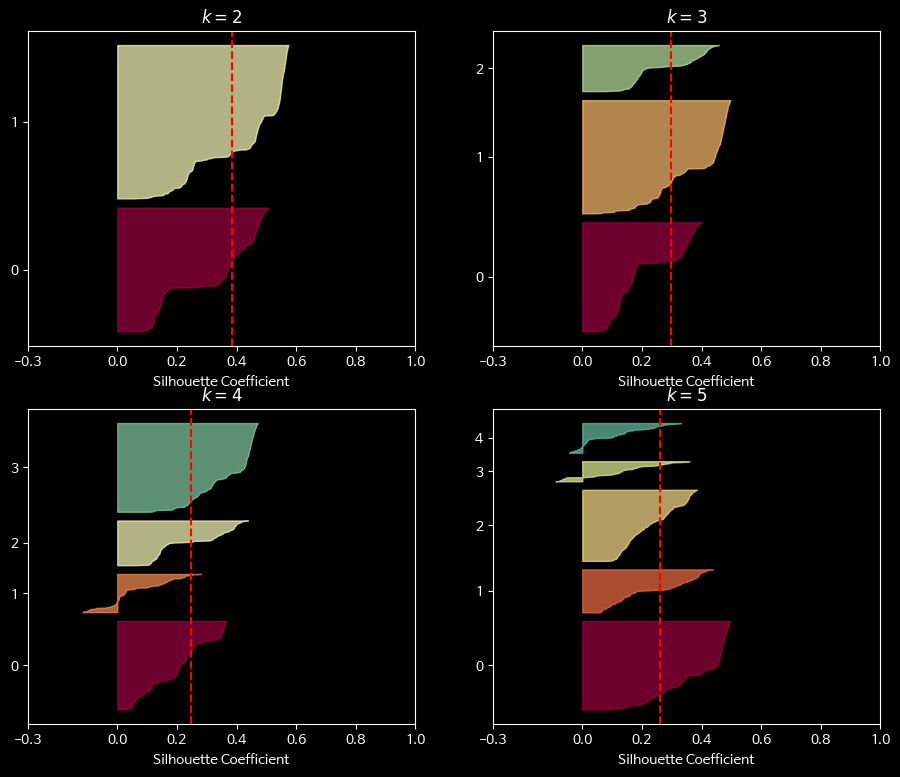

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)

    y_pred = k_means[k - 1].labels_

    silhouette_coefficients = silhouette_samples(df_encoded, y_pred)

    padding = len(df_encoded) // 30
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(k)]))
    plt.gca().set_xticks([-0.3, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.xlabel("Silhouette Coefficient")
    plt.axvline(x=sil_mean_score[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

    plt.xticks([-0.3, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

# K=2 -> 평균 실루엣 계수(빨간 점선)가 가장 높음
# K=3 -> 평균 실루엣 계수가 약간 낮아지긴 함, 추가로 실루엣 칼날(실루엣 계수의 분포)도 K=2에 비해 낮은 값들의 분포가 많음
# K=4, 5 -> 실루엣 칼날이 날카롭고, 평균 실루엣 계수도 낮음 -> 클러스터링의 품질이 저하되었다!

##### 4. 계층 군집(병합, 분할) 활용한 군집수 설정
- Dendrogram : 병합 군집이 어떻게 군집되었는지를 시각화 해놓은 차트
  - 군집별 유사성 비교 가능!
---
- Dendrogram에서 K수 찾는 법!
  1. 수평선 그어보기 : 클러스터 간의 거리(유사도)를 나타내는 수직선들이 있음 -> 그 수직선을 기준으로 어느 높이에서 수평선을 그을지 결정
    > 수직선이 긴(큰 간격) 곳을 선택! : Dendrogram에서 클러스터간의 거리가 급격히 증가하는 부분(즉, 수직선이 긴 부분) 바로 아래에 수평선을 그으면, 해당 수평선이 지나가는 클러스터 수(수직선들)가 k값이 됨

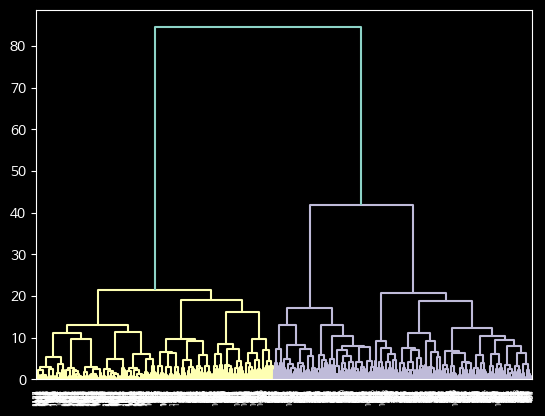

In [ ]:
import scipy.cluster.hierarchy as shc # 병한군집을 위한 도구

# 덴드로그램 시각화
shc.dendrogram(shc.linkage(df_encoded, method = "ward"))
# linkage = () : 덴드로그램에 들어갈 유사도(method 인자로 지정) 계산하는 함수
# method = ward : 거리 계산법 중 1개, 군집 내 분산을 가장 적게 증가시크는 두 군집을 합쳐나가는 방식
plt.show()

# 주의 : 너무 긴 수직선은 피하기! -> 클러스터 개수가 너무 적어질 수 있음!
# 적절한 k수는 2로 채택!

### 적절한 k수(2)로 K-Means 알고리즘 수행!

In [ ]:
model = KMeans(n_clusters = 2, n_init = 10, random_state = 2024) # 최적의 k수로 모델 초기화!

In [ ]:
# 학습하며, 예측값 추출
kmean_pred = model.fit_predict(df_encoded)

In [ ]:
pd.Series(kmean_pred).value_counts()

,count
1,643
0,519


In [ ]:
# 클러스터링 결과를 컬럼으로 추가
df_encoded["cluster"] = kmean_pred

In [ ]:
df_encoded.groupby("cluster").mean()
# cluster별로 잘 나누었는지 특징들을 살펴보려고 하는데, 별 특징이 보이지 않음

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,요일_금,요일_목,요일_수,요일_월,요일_화,조식메뉴_Main_encoded,중식메뉴_Main_encoded,석식메뉴_Main_encoded
cluster,,,,,,,,,,,,,,,,
0,0.236699,0.108493,0.607279,0.261863,0.012555,0.509759,0.481481,0.493256,0.217726,0.200385,0.154143,0.213873,0.213873,5.335260,1.784200,1.682081
1,0.341216,0.116777,0.580707,0.280531,0.141705,0.513834,0.457102,0.506998,0.195956,0.217729,0.185070,0.202177,0.199067,1.706065,1.471229,1.469673


In [ ]:
# cluster별로 메뉴들 확인
df[df_encoded["cluster"] == 1]["중식메뉴_Main"].value_counts()

,count
중식메뉴_Main,
냉이된장찌개,3
오이냉국,3
돈육간장불고기,3
돈육간장볶음,3
치즈함박스테이크,3
...,...
오징어돈육볶음,1
해물까스,1
양파치킨,1


In [ ]:
# 클러스터, 요일별로 중식계와 석식계 확인
df_cluster_0 = df[df_encoded["cluster"] == 0]
df_cluster_1 = df[df_encoded["cluster"] == 1]

In [ ]:
df_0_gp = df_cluster_0.groupby("요일")[["중식계", "석식계"]].mean()

In [ ]:
df_1_gp = df_cluster_1.groupby("요일")[["중식계", "석식계"]].mean()

<BarContainer object of 5 artists>

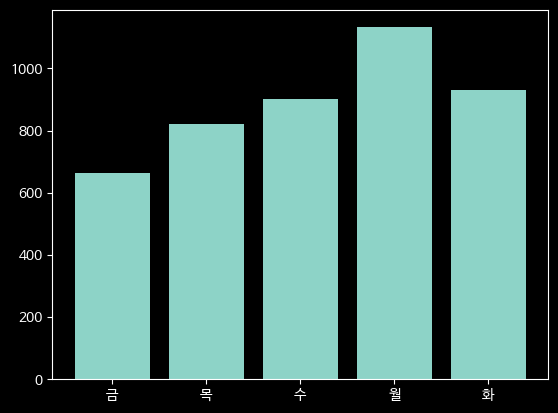

In [ ]:
plt.bar(df_0_gp.index, df_0_gp["중식계"])

<BarContainer object of 5 artists>

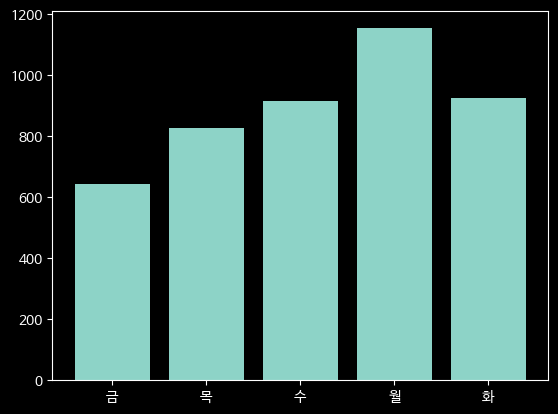

In [ ]:
plt.bar(df_1_gp.index, df_1_gp["중식계"])
# 주 초반(월요일)에 직원들이 회사에 많이 출근하고 점심을 먹는 경향이 있음을 나타냄
# 금요일이 식수가 가장 낮음 -> 금요일에 연차, 출장 등에 의해서 낮아지는 경향이 나타남

##### KMeans(외 거리기반 알고리즘) 장단점
- 장점
  - 구현, 이해하기 쉬움
  - 해석하기도 쉬움
  - 군집이 잘 되어있는 데이터셋에 대해서는 효율적
- 단점
  - 적절한 k수를 찾아야함 -> 여러가지 분석적 접근이 필요함
  - Centroid 중심으로 클러스터링 수행 -> 복잡한 데이터셋에 클러스터링은 처리하기 어려움
  - 이상치에 매우 민감

#### DBSCAN
- 밀도기반 알고리즘
- 밀도있게 연결되어 있는 데이터 집합은 동일한 클러스터로 판단
---
- eps(epsilon) : 개별 데이터포인트 중심으로 반지름
- min_samples : eps 반경 내에 포함되는 데이터 개수, core point(중심 포인트)가 되기 위한 조건
  - 중심포인트 : 군집을 결정짓는 핵심 포인트
  - 경계포인트 : eps 반경 내에 min_samples를 갖추지 못 했는데, core point eps내에는 속하는 포인트
  - 노이즈 포인트 : 중심도 아니고, 경계도 아닌 밀집되지 못 한 데이터 포인트

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


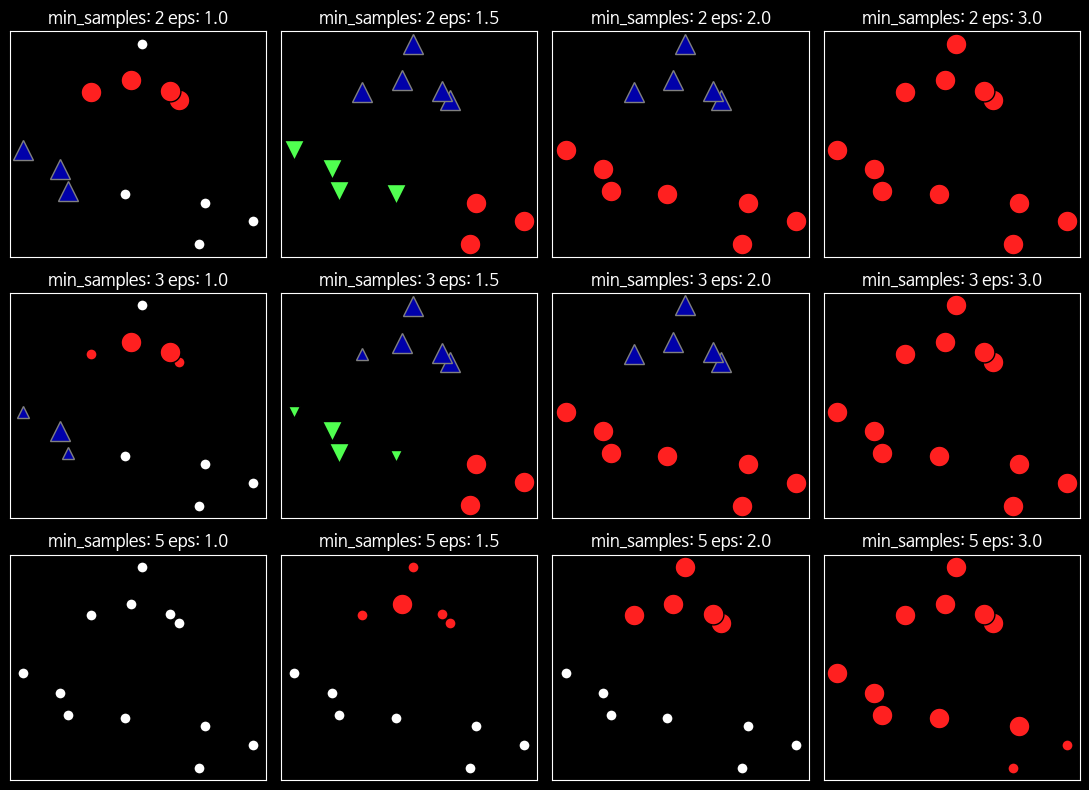

In [ ]:
mglearn.plots.plot_dbscan() # min_samples와 eps에 의한 차이점 시각화
plt.show()
# eps을 증가시킬수록 하나의 클러스터에 더 많은 데이터 포인트가 포함 -> 클러스터 개수가 줄어듬
# min_samples를 증가시킬수록 중심포인트가 줄어들며, noise point 늘어난다!

In [ ]:
df_encoded.drop(columns = ["cluster"], inplace = True)

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps = 0.5, min_samples = 5)

In [ ]:
# 학습하면서 예측값 추출
dbscan_cluster = dbscan.fit_predict(df_encoded)

In [ ]:
len(pd.Series(dbscan_cluster).value_counts())

# -1 : noise point
# 36ea의 label이 형성됨을 확인 -> 적절한 eps, min_samples의 설정이 필요함

37

#### DBSCAN에서의 적절한 하이퍼 파라미터 값 찾아보기!
- 이론적으로 증명된 DBSCAN의 min_pt나 eps을 구할 수 있는 수학적 공식(또는 객관적인 통계치) 같은 것은 없음...
- 다양한 논문에 의한 주관적인 방법으로 min_pt와 eps을 결정하는데 도움을 받을 수는 있음!!
---
1. 일반적인 경험에 의한 min_samples 설정
  - 논문에서는 2차원 데이터인 경우 min_pt를 4로 설정하는 것을 제안
  - 다차원인 경우, min_pt = dim(특성개수) * 2
  - 데이터 포인트 수 n에다가 log(n) 값을 사용 -> min_samples 설정하는 방법!

2. 일반적인 경험에 의한 eps 설정
  - sorted k-dist plot 을 사용하여 결정
  - min_pt를 k로 설정하고, 각각의 데이터 포인트랑 k번째 가까운 이웃 사이의 거리를 계산

In [ ]:
import math # 수학 관련 라이브러리

In [ ]:
# min_samples 설정
n = len(df_encoded) # 데이터 포인트 개수
min_point = math.ceil(np.log(n)) # 로그를 취해서 올림
min_point

8

- k-dist plot 그려보기

In [ ]:
from sklearn.neighbors import NearestNeighbors
# KNN : 거리 계산을 통해 분류, 회귀를 수행하도록 설계된 지도 모델
# NN : 가까운 이웃을 찾기 위함(거리 계산하는 비지도 모델)

In [ ]:
neighbors = NearestNeighbors(n_neighbors = min_point) # 객체 초기화

In [ ]:
neighbors.fit(df_encoded) # 각각의 데이터 포인트 별로, 주변에 데이터 포인트와의 거리를 계산

NearestNeighbors(n_neighbors=8)

In [ ]:
n

1162

In [ ]:
distances, i = neighbors.kneighbors(df_encoded)
# distences : 각 데이터 포인트와의 가장 가까운 8개의 거리값
# i = 8개의 거리값 -> 해당 되는 데이터 포인트의 인덱스

In [ ]:
distances[3], i[3]

(array([0.        , 0.37698375, 0.44444545, 0.57812675, 1.00529824,
        1.00679678, 1.00809473, 1.00973911]),
 array([  3,  66, 555, 957, 245, 255,  10,  15]))

In [ ]:
# 거리를 오름차순 정렬
dist = np.sort(distances, axis=0)
# axis = 0 -> 행방향으로 접근해서, 거리값들을 오름차순으로 정렬

In [ ]:
dist_k = dist[:,min_point - 1] # 인덱스 번호 7번째(거리값들 중에서 가장 큰 값)

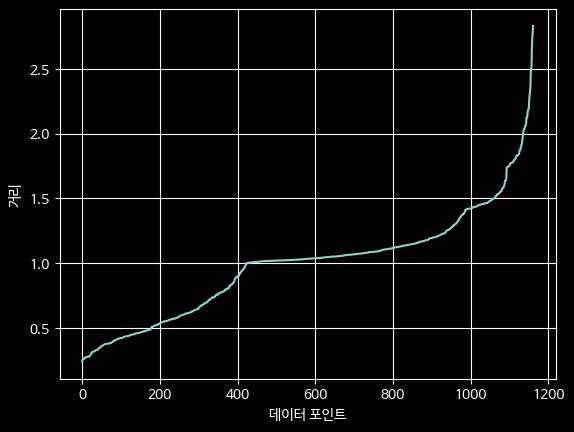

In [ ]:
# k-dist plot 그려보기
plt.plot(dist_k)
plt.xlabel("데이터 포인트")
plt.ylabel("거리")
plt.grid()
plt.show()
# 포인트 -> 급격한 변화가 일어나는 지점 선정
# eps은 1.0, 1.4, 1.75 -> 3군데의 포인트에서 관측됨! (※ 항상 정답은 아님!)

In [ ]:
# 다시 DBSCAN 모델링
dbscan = DBSCAN(eps = 1.4, min_samples = (min_point + 1))
# 적절한 eps 값은 1.4!! (1.0은 너무 많은 클러스터링을 수행, 1.75는 하나의 클러스터로 묶어버림)

dbscan_cluster = dbscan.fit_predict(df_encoded)

pd.Series(dbscan_cluster).value_counts()

,count
2,230
0,229
1,223
3,215
4,180
-1,85


In [ ]:
df_encoded["dbscan_cluster"] = dbscan_cluster

In [ ]:
df_encoded.head(3)

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,요일_금,요일_목,요일_수,요일_월,요일_화,조식메뉴_Main_encoded,중식메뉴_Main_encoded,석식메뉴_Main_encoded,dbscan_cluster
0,0.0,0.022481,0.323442,0.227969,0.0,0.638865,0.283396,0.090909,False,False,False,True,False,1,1,3,2
1,0.0,0.022481,0.391691,0.305556,0.0,0.490972,0.569288,0.090909,False,False,False,False,True,4,3,3,3
2,0.0,0.027477,0.412463,0.106322,0.0,0.619948,0.585518,0.090909,False,False,True,False,False,6,6,1,-1


In [ ]:
# noise 확인
df[df_encoded["dbscan_cluster"] == -1] # 이상치(거리가 월등히 떨어져있는 데이터 포인트들)

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
2,수,2601,56,180,111,0.0,1017.0,573.0,2,느타리호박볶음,견과류조림,새송이버섯볶음
5,목,2601,383,143,417,0.0,1045.0,550.0,2,감자찌개,시래기국,군만두
19,목,2624,61,224,351,0.0,1000.0,473.0,3,가지볶음,새송이버섯조림,군고구마
34,목,2624,53,251,293,0.0,876.0,507.0,3,순두부국,시래기나물,군만두
38,수,2624,48,230,0,0.0,1033.0,463.0,3,참나물무침,봄새싹비빔밥,애호박나물
...,...,...,...,...,...,...,...,...,...,...,...,...
924,화,2821,96,236,388,0.0,820.0,272.0,1,감자양파국,함박스테이크,군만두
937,수,2872,62,215,4,0.0,660.0,276.0,2,만두국,주꾸미초무침,오꼬노미야끼계란말이
941,화,2872,52,198,748,0.0,1075.0,668.0,2,알감자조림,냉이된장찌개,짜장잡채덮밥
947,수,2872,62,224,1,0.0,930.0,434.0,2,김잔파무침,도라지오이생채,닭가슴살냉채


In [ ]:
# noise 삭제
df_clean = df[df_encoded["dbscan_cluster"] != -1] # 원본
df_encoded_clean = df_encoded[df_encoded["dbscan_cluster"] != -1] # 인코딩 된 DF

In [ ]:
# noise 삭제 확인
dbscan = DBSCAN(eps = 1.4, min_samples = (min_point + 1))

dbscan_cluster = dbscan.fit_predict(df_encoded_clean)

pd.Series(dbscan_cluster).value_counts()

,count
2,230
0,229
1,223
3,215
4,180


In [ ]:
df_clean[df_encoded_clean["dbscan_cluster"] == 2]

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
0,월,2601,50,150,238,0.0,1039.0,331.0,2,쥐어채무침,오징어찌개,건파래무침
7,월,2601,87,204,482,0.0,1268.0,672.0,2,콩조림,닭감자조림,임연수구이
12,월,2601,90,207,434,0.0,1298.0,645.0,2,브로컬리죽,고사리,부추오이생채
17,월,2601,595,168,110,0.0,869.0,344.0,2,곰피초장,치커리생채,구이김
21,월,2624,50,195,456,0.0,1326.0,625.0,3,쑥갓무침,모둠묵,대구찌개
...,...,...,...,...,...,...,...,...,...,...,...,...
1141,월,2990,248,153,526,339.0,1256.0,327.0,12,소보로빵,바지락살무국,어떡햄
1145,월,2983,92,91,490,340.0,1405.0,598.0,1,리코타치즈샐러드,봉추찜닭,소고기콜라비조림
1150,월,2983,105,158,517,369.0,1257.0,451.0,1,증편,쪽파무침,고구마연근맛탕
1155,월,2983,67,163,509,357.0,1277.0,460.0,1,달래양념장,감자채카레볶음,낙지미나리볶음


In [ ]:
clusters = {} # 클러스터별로 담아둘 딕셔너리
for cluster_num in range(len(df_encoded_clean["dbscan_cluster"].unique())) : # 0 ~ 4
  clusters[cluster_num] = df_clean[df_encoded_clean["dbscan_cluster"] == cluster_num]

In [ ]:
# 클러스터별로 통계치 확인
for cluster_num, data in clusters.items() :
  print(f"클러스터 {cluster_num} 범주형 통계치")
  display(data.describe(include = "object").T)
# 요일이라는 컬럼이 클러스터링에 있어서 가장 많은 영향을 줌

클러스터 0 범주형 통계치


,count,unique,top,freq
요일,229,1,목,229
조식메뉴_Main,229,180,삶은계란,5
중식메뉴_Main,229,217,부추전,2
석식메뉴_Main,229,204,옛날왕돈까스,3


클러스터 1 범주형 통계치


,count,unique,top,freq
요일,223,1,금,223
조식메뉴_Main,223,174,우거지해장국,4
중식메뉴_Main,223,208,건파래무침,2
석식메뉴_Main,223,207,미니함박조림,3


클러스터 2 범주형 통계치


,count,unique,top,freq
요일,230,1,월,230
조식메뉴_Main,230,175,핫케익,5
중식메뉴_Main,230,200,야채계란찜,3
석식메뉴_Main,230,217,땅콩조림,3


클러스터 3 범주형 통계치


,count,unique,top,freq
요일,215,1,화,215
조식메뉴_Main,215,177,쑥갓두부무침,5
중식메뉴_Main,215,202,김치찌개,3
석식메뉴_Main,215,193,콩나물밥,2


클러스터 4 범주형 통계치


,count,unique,top,freq
요일,180,1,수,180
조식메뉴_Main,180,151,대구매운탕,4
중식메뉴_Main,180,171,산채비빔밥,3
석식메뉴_Main,180,170,잔멸치볶음,2


### 예측 모델 구축을 통한 중식계와 석식계 별로 분석
- tree 기반 모델 -> 특성 중요도 계산
- target : 중식계, 석식계

In [ ]:
# X, y 로 분리
X = df_encoded_clean.drop(columns = ["중식계", "석식계"])

y_lunch = df_clean["중식계"]
y_dinner = df_clean["석식계"]

In [ ]:
# train, test 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_lunch_train, y_lunch_test, y_dinner_train, y_dinner_test = train_test_split(X, y_lunch, y_dinner, test_size = 0.25, random_state = 2024)

In [ ]:
X_train.shape, X_test.shape, y_lunch_train.shape, y_lunch_test.shape, y_dinner_train.shape, y_dinner_test.shape

((807, 15), (270, 15), (807,), (270,), (807,), (270,))

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# 중식계 모델
model_lunch = XGBRegressor(
    colsample_bytree = 0.8, # 각각의 트리를 구성할 때 사용할 특성 중에서 80%만큼 사용
    learning_rate = 0.1, # 학습률(기울기의 보폭)
    max_depth = 3, # 각 트리의 깊이
    n_estimators = 200, # 트리 개수
    subsample = 0.8, # 각 트리를 학습할 때 행을 80%만 사용
    random_state = 2024
)

model_lunch.fit(X_train, y_lunch_train) # 학습
y_lunch_pred = model_lunch.predict(X_test) # 예측

# 성능평가
lunch_mse = mean_squared_error(y_lunch_test, y_lunch_pred)
lunch_r2 = r2_score(y_lunch_test, y_lunch_pred)

######## 경계선

# 석식계 모델
model_dinner = XGBRegressor(
    colsample_bytree = 0.8, # 각각의 트리를 구성할 때 사용할 특성 중에서 80%만큼 사용
    learning_rate = 0.1, # 학습률(기울기의 보폭)
    max_depth = 3, # 각 트리의 깊이
    n_estimators = 200, # 트리 개수
    subsample = 0.8, # 각 트리를 학습할 때 행을 80%만 사용
    random_state = 2024
)

model_dinner.fit(X_train, y_dinner_train) # 학습
y_dinner_pred = model_dinner.predict(X_test) # 예측

# 성능평가
dinner_mse = mean_squared_error(y_dinner_test, y_dinner_pred)
dinner_r2 = r2_score(y_dinner_test, y_dinner_pred)

In [ ]:
# 특성 중요도 그리는 함수 정의
def plot_feature_importances(models, titles, feature_names) :
  fig, axes = plt.subplots(1, len(models), figsize = (16, 6))

  for i, (model, title) in enumerate(zip(models, titles)) :
    importances = model.feature_importances_ # 특성 중요도
    indices = np.argsort(importances)[::-1] # 내림차순 정렬 -> 인덱스를 반환

    axes[i].bar(range(len(indices)), importances[indices], align = "center")
    axes[i].set_xticks(range(len(indices)))
    axes[i].set_xticklabels(feature_names[indices], rotation = 70)
    axes[i].set_title(title)

  plt.tight_layout() # 레이아웃을 조정 -> 보기좋게 그려줌
  plt.show()

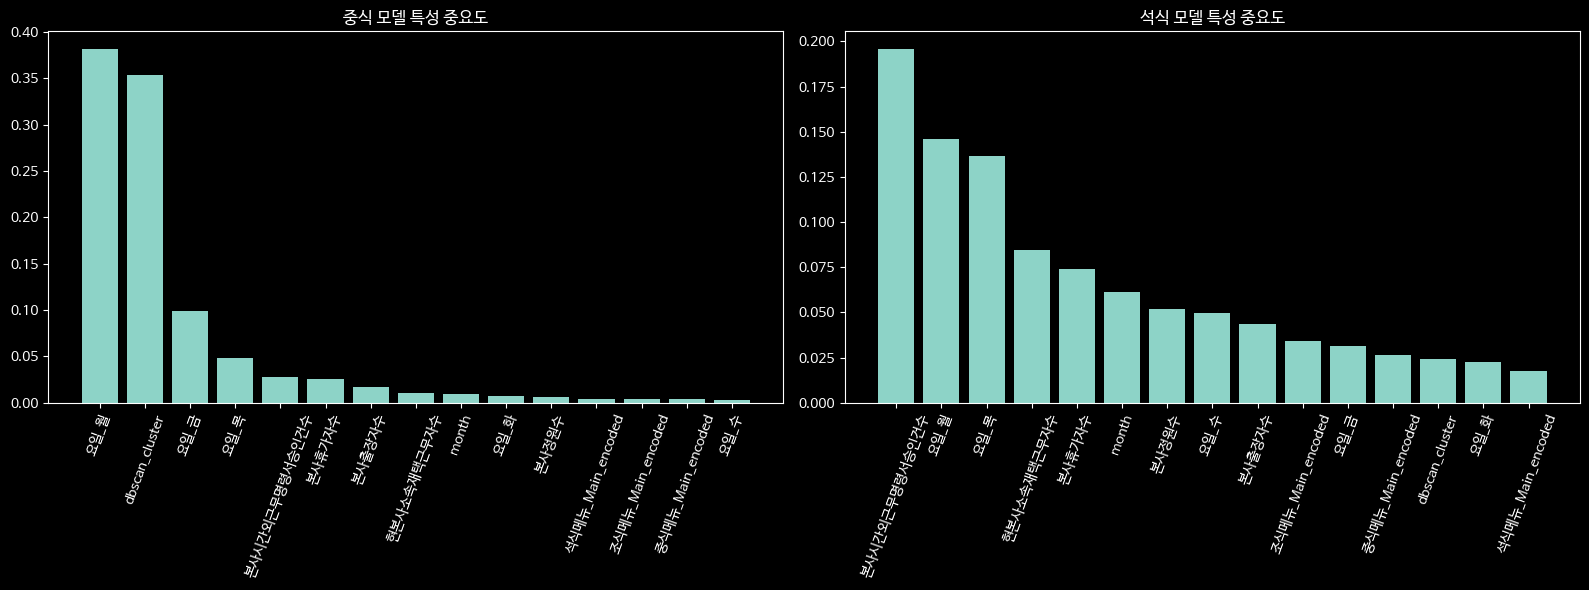

In [ ]:
models = [model_lunch, model_dinner]
titles = ["중식 모델 특성 중요도", "석식 모델 특성 중요도"]
feature_names = X.columns

plot_feature_importances(models, titles, feature_names)

# 중식계 전략 : 요일과 cluster가 가장 많은 영향을 미침 -> 중식 재고를 준비하는데 있어서 가장 고려해야 할 특성들
# 석식계 전략 : 야근 횟수와 요일이 가장 많은 영향을 미침 -> 석식 재고를 준비하는데 있어서 가장 고려해야 할 특성들